In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

In [3]:
# Define the days
next_28_days_600 = [f'd_{i}' for i in range(600, 629)]

In [4]:
# Compute total sales
sales_next_28_600 = sales_train_validation[['item_id', 'store_id', 'state_id'] + next_28_days_600].copy()
sales_next_28_600['total_sales'] = sales_next_28_600[next_28_days_600].sum(axis=1)


In [5]:
# Filter non-zero sales
active_next_sales_600 = sales_next_28_600[sales_next_28_600['total_sales'] > 0]


In [6]:
# Unique IDs
items_600 = active_next_sales_600['item_id'].unique()
stores_600 = active_next_sales_600['store_id'].unique()
states_600 = active_next_sales_600['state_id'].unique()

In [7]:
# Forecasts
item_forecasts_600 = active_next_sales_600.groupby('item_id')[next_28_days_600].mean().mean(axis=1).reset_index()
item_forecasts_600.columns = ['item_id', 'forecast']

In [8]:
store_forecasts_600 = active_next_sales_600.groupby('store_id')[next_28_days_600].mean().mean(axis=1).reset_index()
store_forecasts_600.columns = ['store_id', 'forecast']

In [9]:
state_forecasts_600 = active_next_sales_600.groupby('state_id')[next_28_days_600].mean().mean(axis=1).reset_index()
state_forecasts_600.columns = ['state_id', 'forecast']

In [10]:
total_forecast_600 = active_next_sales_600[next_28_days_600].mean().mean()
total_forecast_600 = pd.DataFrame({'level': ['total'], 'forecast': [total_forecast_600]})


In [11]:
# Summing Matrix
item_to_store_600 = active_next_sales_600[['item_id', 'store_id']].drop_duplicates().set_index('item_id')['store_id']
item_to_state_600 = active_next_sales_600[['item_id', 'state_id']].drop_duplicates().set_index('item_id')['state_id']


In [12]:
n_items = len(items_600)
n_stores = len(stores_600)
n_states = len(states_600)
n_total = 1
n_total_nodes = n_total + n_states + n_stores + n_items
n_bottom = n_items

In [13]:
S_600 = np.zeros((n_total_nodes, n_bottom))

In [14]:
item_idx_600 = {item: i for i, item in enumerate(items_600)}
store_idx_600 = {store: i + n_total + n_states for i, store in enumerate(stores_600)}
state_idx_600 = {state: i + n_total for i, state in enumerate(states_600)}
total_idx_600 = 0


In [15]:
S_600[total_idx_600, :] = 1

In [16]:
for item in items_600:
    state = item_to_state_600.loc[item]
    store = item_to_store_600.loc[item]
    if isinstance(state, pd.Series): state = state.iloc[0]
    if isinstance(store, pd.Series): store = store.iloc[0]
    S_600[state_idx_600[state], item_idx_600[item]] = 1
    S_600[store_idx_600[store], item_idx_600[item]] = 1

for i in range(n_items):
    S_600[n_total + n_states + n_stores + i, i] = 1

In [17]:
# Base forecast vector
base_forecasts_600 = np.zeros(n_total_nodes)
base_forecasts_600[total_idx_600] = total_forecast_600['forecast'].values[0]
for state in states_600:
    base_forecasts_600[state_idx_600[state]] = state_forecasts_600[state_forecasts_600['state_id'] == state]['forecast'].values[0]
for store in stores_600:
    base_forecasts_600[store_idx_600[store]] = store_forecasts_600[store_forecasts_600['store_id'] == store]['forecast'].values[0]
for item in items_600:
    base_forecasts_600[n_total + n_states + n_stores + item_idx_600[item]] = item_forecasts_600[item_forecasts_600['item_id'] == item]['forecast'].values[0]


In [18]:
# BU and MinT
bu_forecasts_600 = np.dot(S_600, base_forecasts_600[n_total + n_states + n_stores:])
G_600 = np.linalg.pinv(S_600.T @ S_600) @ S_600.T
reconciled_forecasts_600 = np.dot(S_600, G_600 @ base_forecasts_600)

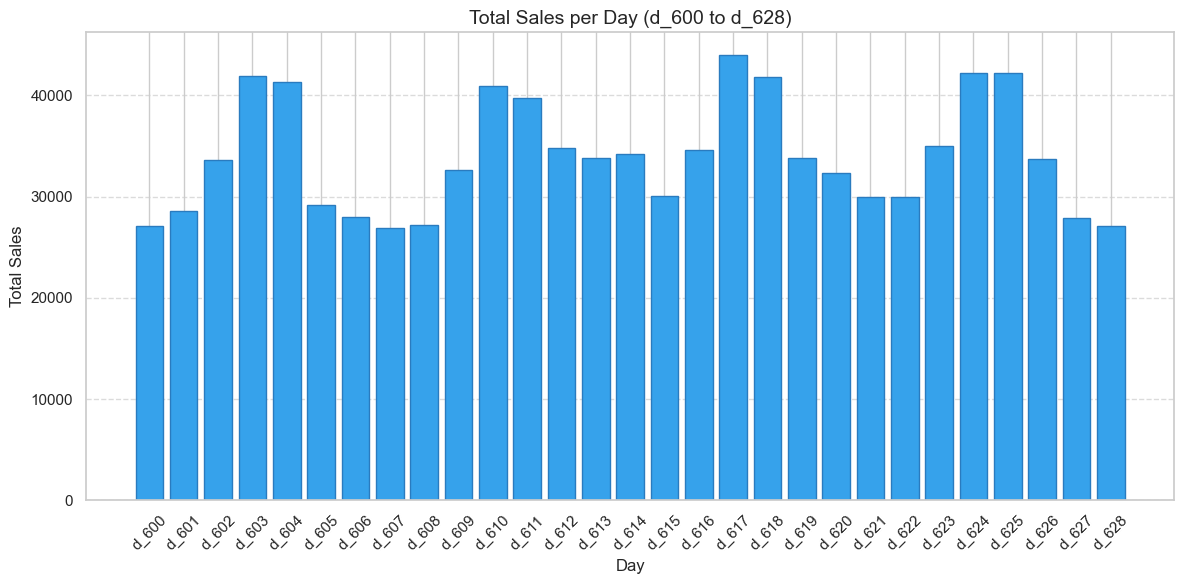

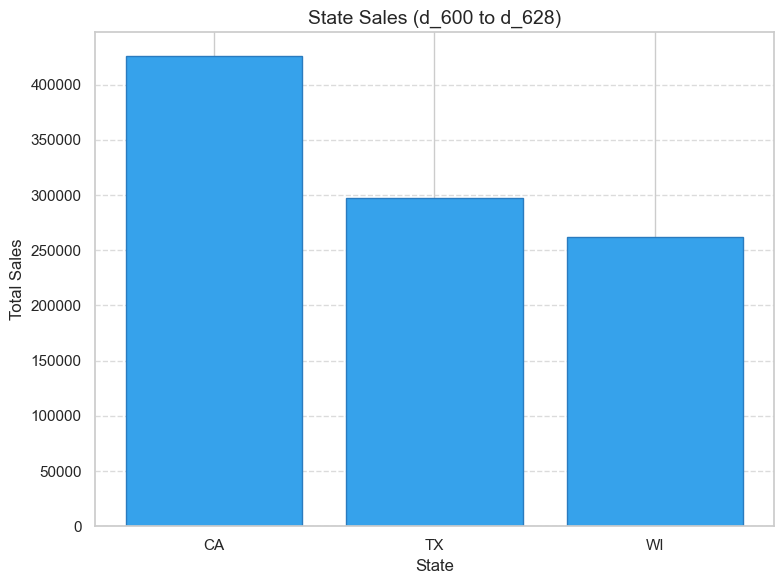

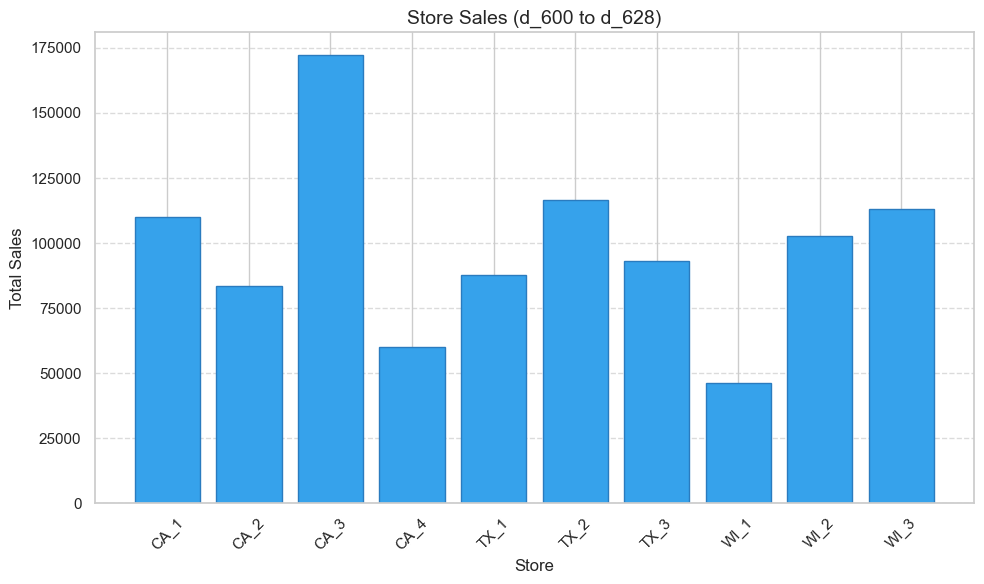

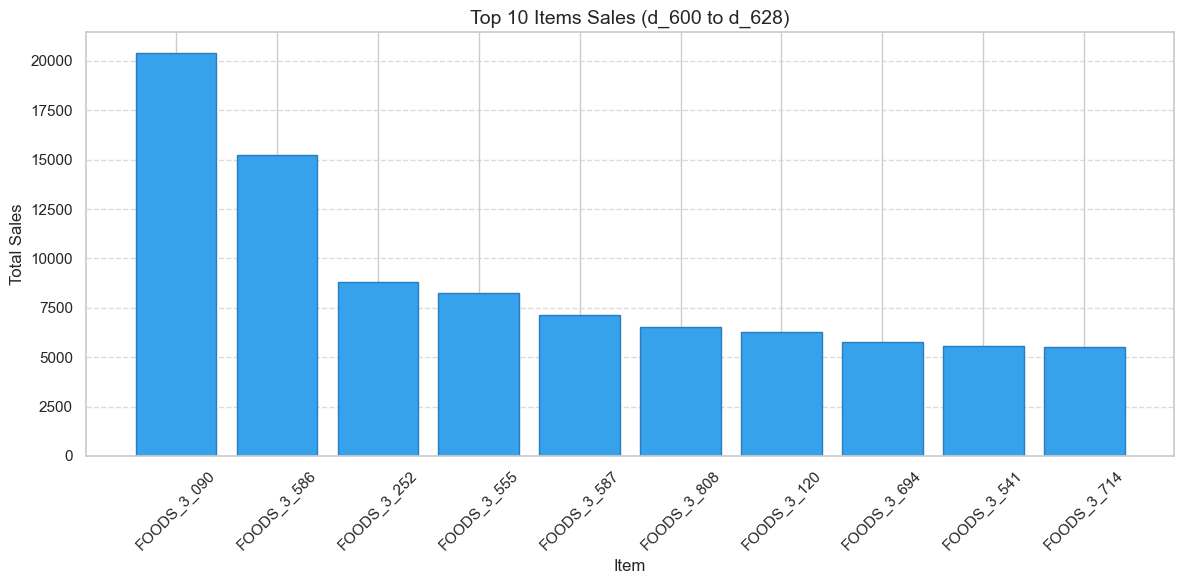

In [19]:
# Plotting
sns.set(style="whitegrid")

# Total Sales per Day
plt.figure(figsize=(12, 6))
plt.bar(next_28_days_600, active_next_sales_600[next_28_days_600].sum(), color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Total Sales per Day (d_600 to d_628)', fontsize=14)
plt.xlabel('Day', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('total_sales_per_day_600_628.png')
plt.show()

# State Sales
state_sales_600 = active_next_sales_600.groupby('state_id')[next_28_days_600].sum().sum(axis=1).reset_index()
state_sales_600.columns = ['state_id', 'total_sales']

plt.figure(figsize=(8, 6))
plt.bar(state_sales_600['state_id'], state_sales_600['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('State Sales (d_600 to d_628)', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('state_sales_600_628.png')
plt.show()

# Store Sales
store_sales_600 = active_next_sales_600.groupby('store_id')[next_28_days_600].sum().sum(axis=1).reset_index()
store_sales_600.columns = ['store_id', 'total_sales']

plt.figure(figsize=(10, 6))
plt.bar(store_sales_600['store_id'], store_sales_600['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Store Sales (d_600 to d_628)', fontsize=14)
plt.xlabel('Store', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('store_sales_600_628.png')
plt.show()

# Top 10 Items Sales
item_sales_600 = active_next_sales_600.groupby('item_id')[next_28_days_600].sum().sum(axis=1).reset_index()
item_sales_600.columns = ['item_id', 'total_sales']
top_10_items_600 = item_sales_600.nlargest(10, 'total_sales')

plt.figure(figsize=(12, 6))
plt.bar(top_10_items_600['item_id'], top_10_items_600['total_sales'], color='#36A2EB', edgecolor='#2A7BBF')
plt.title('Top 10 Items Sales (d_600 to d_628)', fontsize=14)
plt.xlabel('Item', fontsize=12)
plt.ylabel('Total Sales', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_10_items_sales_600_628.png')
plt.show()


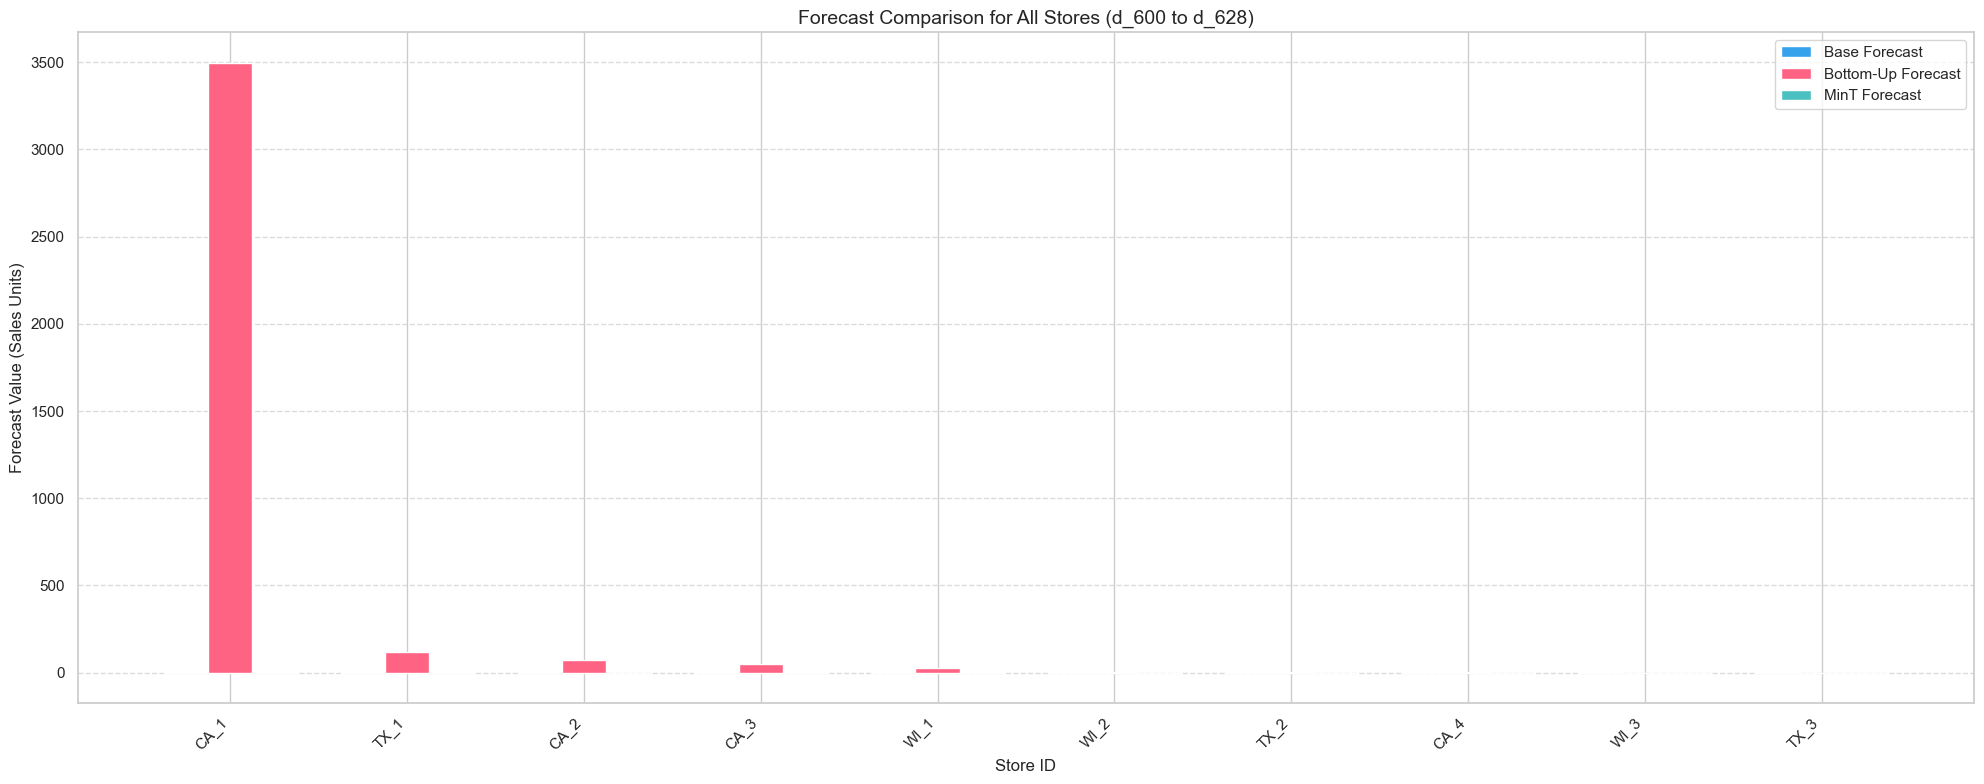

In [20]:
# Reconciled DataFrame
reconciled_df_600_628 = pd.DataFrame({
    'level': ['total'] + list(states_600) + list(stores_600) + list(items_600),
    'base_forecast': base_forecasts_600,
    'bu_forecast': bu_forecasts_600,
    'mint_forecast': reconciled_forecasts_600
})

# Store-level forecast comparison
store_sales_600 = active_next_sales_600.groupby('store_id')[next_28_days_600].sum().sum(axis=1).reset_index()
store_sales_600.columns = ['store_id', 'total_sales']

store_df_600_628 = reconciled_df_600_628[reconciled_df_600_628['level'].isin(store_sales_600['store_id'])].copy()
store_df_600_628['avg_forecast'] = store_df_600_628[['base_forecast', 'bu_forecast', 'mint_forecast']].mean(axis=1)
store_df_600_628 = store_df_600_628.sort_values(by='avg_forecast', ascending=False)

# Plot comparison
fig, ax = plt.subplots(figsize=(20, 8))
bar_width = 0.25
index = np.arange(len(store_df_600_628))

ax.bar(index, store_df_600_628['base_forecast'], bar_width, label='Base Forecast', color='#36A2EB')
ax.bar(index + bar_width, store_df_600_628['bu_forecast'], bar_width, label='Bottom-Up Forecast', color='#FF6384')
ax.bar(index + 2 * bar_width, store_df_600_628['mint_forecast'], bar_width, label='MinT Forecast', color='#4BC0C0')

ax.set_xlabel('Store ID', fontsize=12)
ax.set_ylabel('Forecast Value (Sales Units)', fontsize=12)
ax.set_title('Forecast Comparison for All Stores (d_600 to d_628)', fontsize=14)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(store_df_600_628['level'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('forecast_comparison_all_stores_600_628.png')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Set seaborn style
sns.set(style="whitegrid")

# Load data
sales_train_validation = pd.read_csv('m5_data/sales_train_validation.csv')

# Define days
next_28_days_600 = [f'd_{i}' for i in range(600, 629)]  # d_600 to d_628 (29 days)

# Compute total sales for filtering
sales_next_28_600 = sales_train_validation[['item_id', 'store_id', 'state_id'] + next_28_days_600].copy()
sales_next_28_600['total_sales'] = sales_next_28_600[next_28_days_600].sum(axis=1)

# Filter non-zero sales
active_next_sales_600 = sales_next_28_600[sales_next_28_600['total_sales'] > 0]

# Unique IDs
items_600 = active_next_sales_600['item_id'].unique()
stores_600 = active_next_sales_600['store_id'].unique()
states_600 = active_next_sales_600['state_id'].unique()

# --- XGBoost Data Preparation ---
# Historical days for features
historical_days = [f'd_{i}' for i in range(1, 600)]  # d_1 to d_599

# Function to create features for an item
def create_features(df, item_id, historical_days, forecast_days):
    item_df = df[df['item_id'] == item_id][historical_days + forecast_days].copy()
    sales = item_df[historical_days].values.flatten()
    
    # Create lagged features for training
    features = []
    target = []
    for t in range(28, len(sales)):
        feat = {
            'lag_1': sales[t-1],
            'lag_7': sales[t-7],
            'lag_28': sales[t-28],
            'mean_7': np.mean(sales[t-7:t]),
            'mean_28': np.mean(sales[t-28:t])
        }
        features.append(feat)
        target.append(sales[t])
    
    # Features for forecasting d_600 to d_628
    forecast_features = []
    last_sales = sales[-28:]  # Last 28 days before d_600
    forecast_sales = []
    for t in range(29):
        feat = {
            'lag_1': last_sales[-1] if t == 0 else forecast_sales[t-1],
            'lag_7': last_sales[-7] if t < 7 else forecast_sales[t-7],
            'lag_28': last_sales[-28] if t < 28 else forecast_sales[t-28],
            'mean_7': np.mean(last_sales[-7:]) if t < 7 else np.mean(forecast_sales[max(0, t-7):t]),
            'mean_28': np.mean(last_sales[-28:]) if t < 28 else np.mean(forecast_sales[max(0, t-28):t])
        }
        forecast_features.append(feat)
        forecast_sales.append(0)  # Placeholder
    
    return features, target, forecast_features

# Train XGBoost and forecast
xgb_forecasts = {}
for item in items_600:
    features, target, forecast_features = create_features(
        sales_train_validation, item, historical_days, next_28_days_600
    )
    if len(features) == 0:  # Skip items with insufficient data
        xgb_forecasts[item] = np.zeros(29)
        continue
    
    # Convert to DataFrame
    X_train = pd.DataFrame(features)
    y_train = np.array(target)
    X_forecast = pd.DataFrame(forecast_features)
    
    # Train XGBoost
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Forecast iteratively
    forecast_sales = []
    for t in range(29):
        pred = model.predict(X_forecast.iloc[t:t+1])[0]
        forecast_sales.append(max(0, pred))  # Non-negative predictions
        if t < 28:
            X_forecast.at[t+1, 'lag_1'] = pred
            if t < 22:
                X_forecast.at[t+7, 'lag_7'] = pred
            if t < 1:
                X_forecast.at[t+28, 'lag_28'] = pred
            X_forecast.at[t+1, 'mean_7'] = np.mean(forecast_sales[-7:] + [pred] * (7 - min(t+1, 7)))
            X_forecast.at[t+1, 'mean_28'] = np.mean(forecast_sales[-28:] + [pred] * (28 - min(t+1, 28)))
    
    xgb_forecasts[item] = np.array(forecast_sales)

# Aggregate XGBoost forecasts (mean across days)
item_forecasts_xgb = pd.DataFrame({
    'item_id': items_600,
    'forecast': [np.mean(xgb_forecasts[item]) for item in items_600]
})

# --- Original Forecasts ---
item_forecasts_600 = active_next_sales_600.groupby('item_id')[next_28_days_600].mean().mean(axis=1).reset_index()
item_forecasts_600.columns = ['item_id', 'forecast']

store_forecasts_600 = active_next_sales_600.groupby('store_id')[next_28_days_600].mean().mean(axis=1).reset_index()
store_forecasts_600.columns = ['store_id', 'forecast']

state_forecasts_600 = active_next_sales_600.groupby('state_id')[next_28_days_600].mean().mean(axis=1).reset_index()
state_forecasts_600.columns = ['state_id', 'forecast']

total_forecast_600 = pd.DataFrame({
    'level': ['total'],
    'forecast': [active_next_sales_600[next_28_days_600].mean().mean()]
})

# --- Summing Matrix ---
item_to_store_600 = active_next_sales_600[['item_id', 'store_id']].drop_duplicates().set_index('item_id')['store_id']
item_to_state_600 = active_next_sales_600[['item_id', 'state_id']].drop_duplicates().set_index('item_id')['state_id']

n_items = len(items_600)
n_stores = len(stores_600)
n_states = len(states_600)
n_total = 1
n_total_nodes = n_total + n_states + n_stores + n_items
n_bottom = n_items

S_600 = np.zeros((n_total_nodes, n_bottom))

item_idx_600 = {item: i for i, item in enumerate(items_600)}
store_idx_600 = {store: i + n_total + n_states for i, store in enumerate(stores_600)}
state_idx_600 = {state: i + n_total for i, state in enumerate(states_600)}
total_idx_600 = 0

S_600[total_idx_600, :] = 1

for item in items_600:
    state = item_to_state_600[item]
    store = item_to_store_600[item]
    if isinstance(state, pd.Series):
        state = state.iloc[0]
    if isinstance(store, pd.Series):
        store = store.iloc[0]
    S_600[state_idx_600[state], item_idx_600[item]] = 1
    S_600[store_idx_600[store], item_idx_600[item]] = 1

for i in range(n_items):
    S_600[n_total + n_states + n_stores + i, i] = 1

# --- Base Forecasts (Original) ---
base_forecasts_600 = np.zeros(n_total_nodes)
base_forecasts_600[total_idx_600] = total_forecast_600['forecast'].values[0]
for state in states_600:
    base_forecasts_600[state_idx_600[state]] = state_forecasts_600[state_forecasts_600['state_id'] == state]['forecast'].values[0]
for store in stores_600:
    base_forecasts_600[store_idx_600[store]] = store_forecasts_600[store_forecasts_600['store_id'] == store]['forecast'].values[0]
for item in items_600:
    base_forecasts_600[n_total + n_states + n_stores + item_idx_600[item]] = item_forecasts_600[item_forecasts_600['item_id'] == item]['forecast'].values[0]

# --- BU and MinT Forecasts ---
bu_forecasts_600 = np.dot(S_600, base_forecasts_600[n_total + n_states + n_stores:])
G_600 = np.linalg.pinv(S_600.T @ S_600) @ S_600.T
mint_forecasts_600 = np.dot(S_600, G_600 @ base_forecasts_600)

# --- XGBoost Reconciled Forecasts ---
xgb_base_forecasts_600 = np.zeros(n_total_nodes)
xgb_base_forecasts_600[total_idx_600] = item_forecasts_xgb['forecast'].sum()  # Sum for total
for state in states_600:
    state_items = active_next_sales_600[active_next_sales_600['state_id'] == state]['item_id'].values
    xgb_base_forecasts_600[state_idx_600[state]] = item_forecasts_xgb[item_forecasts_xgb['item_id'].isin(state_items)]['forecast'].sum()
for store in stores_600:
    store_items = active_next_sales_600[active_next_sales_600['store_id'] == store]['item_id'].values
    xgb_base_forecasts_600[store_idx_600[store]] = item_forecasts_xgb[item_forecasts_xgb['item_id'].isin(store_items)]['forecast'].sum()
for item in items_600:
    xgb_base_forecasts_600[n_total + n_states + n_stores + item_idx_600[item]] = item_forecasts_xgb[item_forecasts_xgb['item_id'] == item]['forecast'].values[0]

# Reconcile XGBoost forecasts
xgb_mint_forecasts_600 = np.dot(S_600, G_600 @ xgb_base_forecasts_600)

# --- Forecast Comparison ---
reconciled_df_600_628 = pd.DataFrame({
    'level': ['total'] + list(states_600) + list(stores_600) + list(items_600),
    'base_forecast': base_forecasts_600,
    'bu_forecast': bu_forecasts_600,
    'mint_forecast': mint_forecasts_600,
    'xgb_mint_forecast': xgb_mint_forecasts_600
})

# Store-level actuals (mean sales for consistency)
store_sales_600 = active_next_sales_600.groupby('store_id')[next_28_days_600].mean().mean(axis=1).reset_index()
store_sales_600.columns = ['store_id', 'actual_sales']

# Merge for comparison
store_comparison_df_600 = reconciled_df_600_628[reconciled_df_600_628['level'].isin(store_sales_600['store_id'])].copy()
store_comparison_df_600 = pd.merge(store_comparison_df_600, store_sales_600, left_on='level', right_on='store_id')

# Compute RMSE
rmse_metrics = {
    'Base': mean_squared_error(store_comparison_df_600['actual_sales'], store_comparison_df_600['base_forecast'], squared=False),
    'BU': mean_squared_error(store_comparison_df_600['actual_sales'], store_comparison_df_600['bu_forecast'], squared=False),
    'MinT': mean_squared_error(store_comparison_df_600['actual_sales'], store_comparison_df_600['mint_forecast'], squared=False),
    'XGBoost MinT': mean_squared_error(store_comparison_df_600['actual_sales'], store_comparison_df_600['xgb_mint_forecast'], squared=False)
}

# Print RMSE
print("RMSE Comparison for Store-Level Forecasts:")
for method, rmse in rmse_metrics.items():
    print(f"{method}: {rmse:.4f}")

# --- Visualization ---
# Prepare data for seaborn
store_comparison_melted = pd.melt(
    store_comparison_df_600,
    id_vars=['level'],
    value_vars=['base_forecast', 'bu_forecast', 'mint_forecast', 'xgb_mint_forecast'],
    var_name='Forecast Type',
    value_name='Forecast Value'
)
store_comparison_melted['Forecast Type'] = store_comparison_melted['Forecast Type'].map({
    'base_forecast': 'Base',
    'bu_forecast': 'BU',
    'mint_forecast': 'MinT',
    'xgb_mint_forecast': 'XGBoost MinT'
})

# Sort stores by actual sales
store_order = store_comparison_df_600.sort_values('actual_sales', ascending=False)['level']

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=store_comparison_melted,
    x='level',
    y='Forecast Value',
    hue='Forecast Type',
    order=store_order,
    palette=['#36A2EB', '#FF6384', '#4BC0C0', '#FFCE56']
)
plt.xlabel('Store ID', fontsize=12)
plt.ylabel('Forecast Value (Sales Units)', fontsize=12)
plt.title('Forecast Comparison for All Stores (d_600 to d_628)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Forecast Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('forecast_comparison_all_stores_with_xgb_600_628.png')
plt.show()

C:\Users\KIIT\AppData\Local\Temp\ipykernel_21868\3357567567.py:100: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5049006938934326' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_forecast.at[t+1, 'lag_1'] = pred
C:\Users\KIIT\AppData\Local\Temp\ipykernel_21868\3357567567.py:102: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5049006938934326' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_forecast.at[t+7, 'lag_7'] = pred
C:\Users\KIIT\AppData\Local\Temp\ipykernel_21868\3357567567.py:104: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5049006938934326' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_forecast.at[t+28, 'lag_28'] = pred
C:\Users